# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

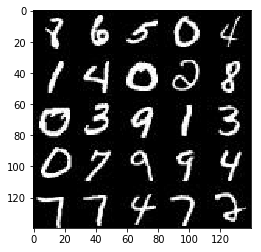

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

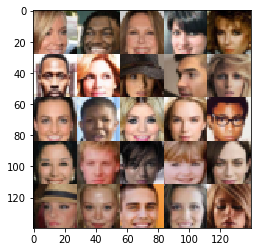

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/Young/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    with tf.name_scope("inputs"):
        input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
        input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
        lr = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5,strides=2, padding='same', use_bias=False, activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(conv1*alpha, conv1)
        #now 14*14*64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5,strides=2, padding='same', use_bias=False, activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2*alpha, conv2)
        #now 7*7*128
        
        flat = tf.reshape(conv2, [-1, 7*7*128])
        logit = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logit)

    return out, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("generator", reuse= not is_train):
        conv1 = tf.layers.dense(z, 7*7*128, use_bias=False)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.reshape(conv1, [-1, 7, 7, 128])
        conv1 = tf.maximum(conv1*alpha, conv1)
        #now 7*7*128
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=2, use_bias=False, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(conv2*alpha, conv2)
        #now 14*14*64
        
        output = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(output) / 2
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    with tf.name_scope('loss'):
        
        g_model = generator(input_z, out_channel_dim, is_train=True)
        d_model_real,d_logit_real = discriminator(input_real, reuse=False)
        d_model_fake,d_logit_fake = discriminator(g_model, reuse=True)
        
        
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_logit_real)*0.9))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))        
        g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))
        
        d_loss = d_loss_real +  d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variable_list = tf.trainable_variables()
    var_d = [var for var in variable_list if var.name.startswith('discriminator')]
    var_g = [var for var in variable_list if var.name.startswith('generator')]
    
    with tf.name_scope('optimizer'):
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=var_d)
            g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=var_g)
    
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    g_opt, d_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    writer_dis = tf.summary.scalar('discrimitor_loss', d_loss)
    writer_gen = tf.summary.scalar('generator_loss', g_loss)
    
    summary_dir = '/tmp/face_generation/'
    file_dis = tf.summary.FileWriter(summary_dir+'discrimitor', 
                                     graph=tf.get_default_graph())
    file_gen = tf.summary.FileWriter(summary_dir+'generator')
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                example_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                feed_dict = {input_real: batch_images,
                             input_z: example_z,
                             lr: learning_rate
                             }
                _ = sess.run(d_opt, feed_dict=feed_dict)
                _ = sess.run(g_opt, feed_dict=feed_dict)
                
                if step % 10 == 0:
                    feed_dict = {input_real: batch_images,
                                 input_z: example_z}
                    dis_loss,gen_loss,sum_dis,sum_gen = sess.run([d_loss,g_loss,writer_dis,writer_gen],
                                                                 feed_dict=feed_dict)
                    file_dis.add_summary(sum_dis, step)
                    file_gen.add_summary(sum_gen, step)
                    
                    print("Epoch {}/{},".format(epoch_i+1,epoch_count),
                          "discrimitor loss:{:.4f}".format(dis_loss),
                           "generator loss:{:.4f}".format(gen_loss))
                    
                if step % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
                step += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, discrimitor loss:1.3235 generator loss:0.7010


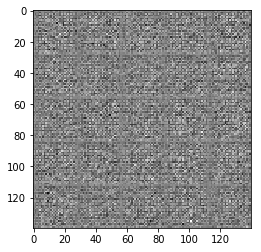

Epoch 1/2, discrimitor loss:0.4911 generator loss:2.5836
Epoch 1/2, discrimitor loss:0.4743 generator loss:2.7101
Epoch 1/2, discrimitor loss:0.4609 generator loss:2.9502
Epoch 1/2, discrimitor loss:0.4913 generator loss:2.4427
Epoch 1/2, discrimitor loss:0.4505 generator loss:2.9358
Epoch 1/2, discrimitor loss:0.4058 generator loss:3.4357
Epoch 1/2, discrimitor loss:0.3971 generator loss:3.6991
Epoch 1/2, discrimitor loss:0.4576 generator loss:2.6245
Epoch 1/2, discrimitor loss:0.4992 generator loss:3.3976
Epoch 1/2, discrimitor loss:0.8398 generator loss:4.2085


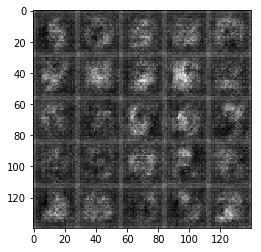

Epoch 1/2, discrimitor loss:0.4789 generator loss:2.4887
Epoch 1/2, discrimitor loss:0.6512 generator loss:3.6736
Epoch 1/2, discrimitor loss:0.6731 generator loss:1.5962
Epoch 1/2, discrimitor loss:0.5519 generator loss:1.9338
Epoch 1/2, discrimitor loss:0.7288 generator loss:1.3365
Epoch 1/2, discrimitor loss:0.5543 generator loss:2.3495
Epoch 1/2, discrimitor loss:0.8243 generator loss:1.1194
Epoch 1/2, discrimitor loss:0.7043 generator loss:1.3901
Epoch 1/2, discrimitor loss:0.6000 generator loss:2.4769
Epoch 1/2, discrimitor loss:0.5962 generator loss:1.7246


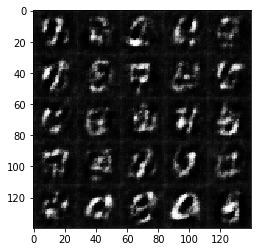

Epoch 1/2, discrimitor loss:0.6110 generator loss:2.1237
Epoch 1/2, discrimitor loss:1.0668 generator loss:3.6153
Epoch 1/2, discrimitor loss:0.6535 generator loss:1.6187
Epoch 1/2, discrimitor loss:0.8180 generator loss:1.0711
Epoch 1/2, discrimitor loss:0.6553 generator loss:1.5481
Epoch 1/2, discrimitor loss:0.6405 generator loss:1.8136
Epoch 1/2, discrimitor loss:0.6594 generator loss:1.6153
Epoch 1/2, discrimitor loss:0.5921 generator loss:2.0456
Epoch 1/2, discrimitor loss:0.9999 generator loss:3.3294
Epoch 1/2, discrimitor loss:0.6461 generator loss:2.4107


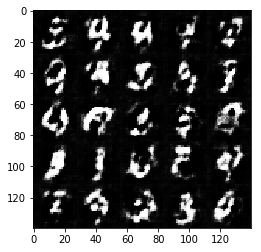

Epoch 1/2, discrimitor loss:0.7112 generator loss:2.4506
Epoch 1/2, discrimitor loss:0.7910 generator loss:1.1078
Epoch 1/2, discrimitor loss:0.7146 generator loss:2.4867
Epoch 1/2, discrimitor loss:0.7457 generator loss:1.4457
Epoch 1/2, discrimitor loss:0.6325 generator loss:1.7321
Epoch 1/2, discrimitor loss:0.6762 generator loss:2.3773
Epoch 1/2, discrimitor loss:0.6930 generator loss:1.5205
Epoch 1/2, discrimitor loss:0.6361 generator loss:2.3217
Epoch 1/2, discrimitor loss:0.7123 generator loss:2.2159
Epoch 1/2, discrimitor loss:0.6371 generator loss:2.4589


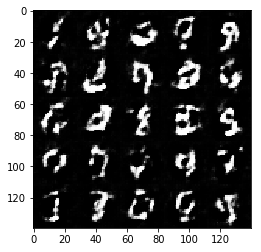

Epoch 1/2, discrimitor loss:0.7097 generator loss:2.0107
Epoch 1/2, discrimitor loss:0.6183 generator loss:2.1061
Epoch 1/2, discrimitor loss:0.6744 generator loss:2.4368
Epoch 1/2, discrimitor loss:0.8533 generator loss:1.0020
Epoch 1/2, discrimitor loss:0.7805 generator loss:2.5329
Epoch 1/2, discrimitor loss:0.7003 generator loss:2.5335
Epoch 1/2, discrimitor loss:0.6447 generator loss:1.5828
Epoch 1/2, discrimitor loss:0.6197 generator loss:2.3827
Epoch 1/2, discrimitor loss:0.6603 generator loss:2.1469
Epoch 1/2, discrimitor loss:0.6735 generator loss:1.7906


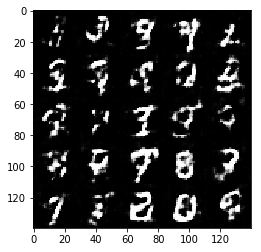

Epoch 1/2, discrimitor loss:0.5956 generator loss:1.8251
Epoch 1/2, discrimitor loss:0.6514 generator loss:2.0244
Epoch 1/2, discrimitor loss:0.7288 generator loss:2.6898
Epoch 1/2, discrimitor loss:0.6636 generator loss:1.5128
Epoch 1/2, discrimitor loss:0.5670 generator loss:1.8295
Epoch 1/2, discrimitor loss:0.6538 generator loss:2.7784
Epoch 1/2, discrimitor loss:0.5910 generator loss:1.8953
Epoch 1/2, discrimitor loss:0.5815 generator loss:1.9176
Epoch 1/2, discrimitor loss:0.5956 generator loss:1.9589
Epoch 1/2, discrimitor loss:0.7832 generator loss:1.1244


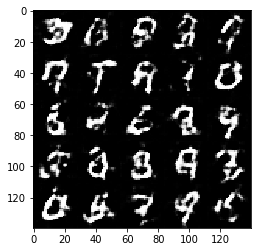

Epoch 1/2, discrimitor loss:0.6300 generator loss:1.9467
Epoch 1/2, discrimitor loss:0.5844 generator loss:1.9093
Epoch 1/2, discrimitor loss:0.6774 generator loss:2.3096
Epoch 1/2, discrimitor loss:0.7431 generator loss:1.2969
Epoch 1/2, discrimitor loss:0.6501 generator loss:1.6418
Epoch 1/2, discrimitor loss:0.7492 generator loss:1.2711
Epoch 1/2, discrimitor loss:0.6389 generator loss:2.5697
Epoch 1/2, discrimitor loss:0.6117 generator loss:1.8697
Epoch 1/2, discrimitor loss:0.5911 generator loss:2.2652
Epoch 1/2, discrimitor loss:0.6450 generator loss:1.6500


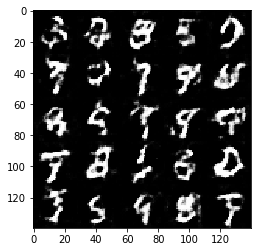

Epoch 1/2, discrimitor loss:0.7259 generator loss:1.2892
Epoch 1/2, discrimitor loss:0.7052 generator loss:1.7449
Epoch 1/2, discrimitor loss:0.6626 generator loss:1.4687
Epoch 1/2, discrimitor loss:0.5875 generator loss:2.6934
Epoch 1/2, discrimitor loss:0.5975 generator loss:2.8089
Epoch 1/2, discrimitor loss:0.7513 generator loss:2.8133
Epoch 1/2, discrimitor loss:0.6287 generator loss:2.7087
Epoch 1/2, discrimitor loss:0.6878 generator loss:2.2660
Epoch 1/2, discrimitor loss:0.6366 generator loss:1.6963
Epoch 1/2, discrimitor loss:0.6254 generator loss:1.8290


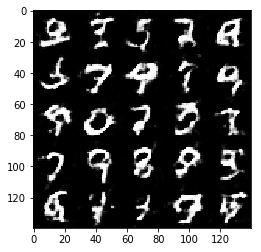

Epoch 1/2, discrimitor loss:0.6438 generator loss:2.3086
Epoch 1/2, discrimitor loss:0.6836 generator loss:2.2028
Epoch 1/2, discrimitor loss:0.7573 generator loss:1.2164
Epoch 1/2, discrimitor loss:0.5198 generator loss:2.0234
Epoch 1/2, discrimitor loss:0.6349 generator loss:2.1526
Epoch 1/2, discrimitor loss:0.6355 generator loss:2.3314
Epoch 1/2, discrimitor loss:0.7763 generator loss:1.2483
Epoch 1/2, discrimitor loss:1.4149 generator loss:0.5474
Epoch 1/2, discrimitor loss:0.6807 generator loss:1.4618
Epoch 1/2, discrimitor loss:0.6920 generator loss:2.3655


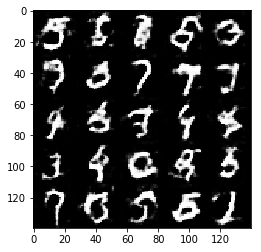

Epoch 1/2, discrimitor loss:0.6992 generator loss:2.2158
Epoch 1/2, discrimitor loss:0.9993 generator loss:0.8723
Epoch 1/2, discrimitor loss:0.6918 generator loss:1.4559
Epoch 2/2, discrimitor loss:0.9121 generator loss:0.9454
Epoch 2/2, discrimitor loss:0.8456 generator loss:1.0430
Epoch 2/2, discrimitor loss:0.5919 generator loss:1.9978
Epoch 2/2, discrimitor loss:0.6258 generator loss:1.7783
Epoch 2/2, discrimitor loss:0.7921 generator loss:1.1904
Epoch 2/2, discrimitor loss:0.7296 generator loss:1.3599
Epoch 2/2, discrimitor loss:0.6078 generator loss:2.1729


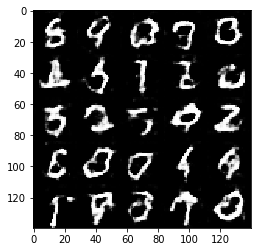

Epoch 2/2, discrimitor loss:0.7956 generator loss:1.1451
Epoch 2/2, discrimitor loss:0.8137 generator loss:2.6420
Epoch 2/2, discrimitor loss:0.6419 generator loss:2.9430
Epoch 2/2, discrimitor loss:0.8412 generator loss:2.9234
Epoch 2/2, discrimitor loss:0.6408 generator loss:1.7238
Epoch 2/2, discrimitor loss:0.7018 generator loss:2.7014
Epoch 2/2, discrimitor loss:0.5970 generator loss:1.8159
Epoch 2/2, discrimitor loss:0.8669 generator loss:3.1578
Epoch 2/2, discrimitor loss:0.6001 generator loss:2.0722
Epoch 2/2, discrimitor loss:0.6584 generator loss:1.8071


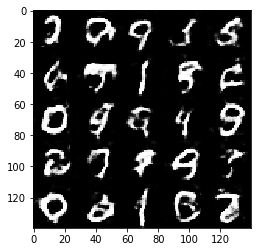

Epoch 2/2, discrimitor loss:0.6409 generator loss:2.9874
Epoch 2/2, discrimitor loss:0.6357 generator loss:2.4839
Epoch 2/2, discrimitor loss:0.7194 generator loss:1.3651
Epoch 2/2, discrimitor loss:0.6185 generator loss:2.1282
Epoch 2/2, discrimitor loss:0.6240 generator loss:2.5631
Epoch 2/2, discrimitor loss:0.6866 generator loss:1.5190
Epoch 2/2, discrimitor loss:0.6610 generator loss:1.4875
Epoch 2/2, discrimitor loss:0.6929 generator loss:2.2737
Epoch 2/2, discrimitor loss:0.5840 generator loss:2.1911
Epoch 2/2, discrimitor loss:0.6034 generator loss:1.8034


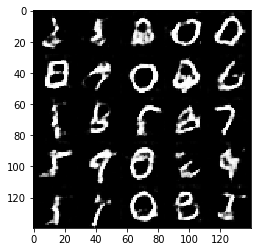

Epoch 2/2, discrimitor loss:0.5934 generator loss:2.1142
Epoch 2/2, discrimitor loss:0.5689 generator loss:1.8483
Epoch 2/2, discrimitor loss:0.7302 generator loss:1.2842
Epoch 2/2, discrimitor loss:0.6500 generator loss:2.4040
Epoch 2/2, discrimitor loss:0.5803 generator loss:2.5436
Epoch 2/2, discrimitor loss:0.7910 generator loss:1.1196
Epoch 2/2, discrimitor loss:0.5423 generator loss:2.1643
Epoch 2/2, discrimitor loss:0.9119 generator loss:3.3507
Epoch 2/2, discrimitor loss:0.6348 generator loss:1.6931
Epoch 2/2, discrimitor loss:0.6176 generator loss:2.3794


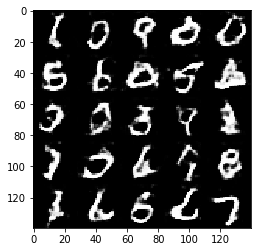

Epoch 2/2, discrimitor loss:0.7324 generator loss:1.2917
Epoch 2/2, discrimitor loss:0.8021 generator loss:3.4633
Epoch 2/2, discrimitor loss:0.5782 generator loss:1.8331
Epoch 2/2, discrimitor loss:0.6334 generator loss:1.5616
Epoch 2/2, discrimitor loss:0.6316 generator loss:1.6076
Epoch 2/2, discrimitor loss:0.6140 generator loss:2.3147
Epoch 2/2, discrimitor loss:0.6288 generator loss:1.9128
Epoch 2/2, discrimitor loss:0.6038 generator loss:1.8360
Epoch 2/2, discrimitor loss:0.6951 generator loss:1.3931
Epoch 2/2, discrimitor loss:0.5660 generator loss:2.3571


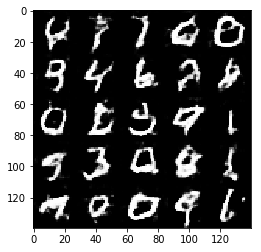

Epoch 2/2, discrimitor loss:0.5958 generator loss:1.7349
Epoch 2/2, discrimitor loss:0.6107 generator loss:1.6527
Epoch 2/2, discrimitor loss:0.5800 generator loss:2.5476
Epoch 2/2, discrimitor loss:0.5459 generator loss:2.2098
Epoch 2/2, discrimitor loss:0.6377 generator loss:1.6548
Epoch 2/2, discrimitor loss:0.6086 generator loss:2.2640
Epoch 2/2, discrimitor loss:0.5915 generator loss:2.2273
Epoch 2/2, discrimitor loss:0.5925 generator loss:3.2335
Epoch 2/2, discrimitor loss:0.5460 generator loss:2.1309
Epoch 2/2, discrimitor loss:0.8085 generator loss:1.1752


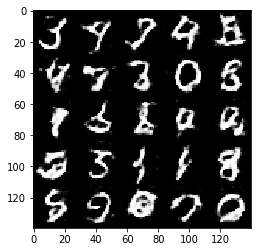

Epoch 2/2, discrimitor loss:0.5349 generator loss:2.2790
Epoch 2/2, discrimitor loss:0.6197 generator loss:1.5572
Epoch 2/2, discrimitor loss:0.7580 generator loss:3.1519
Epoch 2/2, discrimitor loss:0.5611 generator loss:2.0126
Epoch 2/2, discrimitor loss:0.5734 generator loss:1.8991
Epoch 2/2, discrimitor loss:0.7402 generator loss:1.2696
Epoch 2/2, discrimitor loss:0.6022 generator loss:2.5017
Epoch 2/2, discrimitor loss:0.6305 generator loss:1.6119
Epoch 2/2, discrimitor loss:0.5907 generator loss:2.7340
Epoch 2/2, discrimitor loss:0.5422 generator loss:2.1372


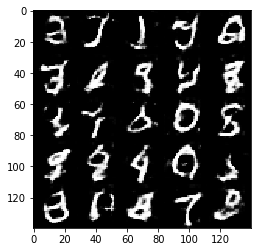

Epoch 2/2, discrimitor loss:0.5751 generator loss:2.6628
Epoch 2/2, discrimitor loss:0.9963 generator loss:0.9126
Epoch 2/2, discrimitor loss:0.5486 generator loss:2.0904
Epoch 2/2, discrimitor loss:0.6746 generator loss:1.3942
Epoch 2/2, discrimitor loss:0.6000 generator loss:1.7067
Epoch 2/2, discrimitor loss:2.0778 generator loss:5.6276
Epoch 2/2, discrimitor loss:0.5710 generator loss:1.9254
Epoch 2/2, discrimitor loss:0.6415 generator loss:1.5972
Epoch 2/2, discrimitor loss:0.6167 generator loss:3.3378
Epoch 2/2, discrimitor loss:0.5812 generator loss:2.2407


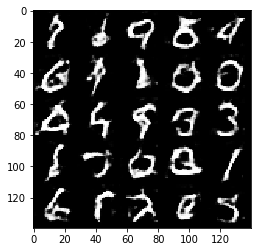

Epoch 2/2, discrimitor loss:0.5806 generator loss:2.3878
Epoch 2/2, discrimitor loss:0.5160 generator loss:2.5065
Epoch 2/2, discrimitor loss:0.6213 generator loss:1.5786
Epoch 2/2, discrimitor loss:0.6781 generator loss:3.2849
Epoch 2/2, discrimitor loss:0.5316 generator loss:2.6727
Epoch 2/2, discrimitor loss:0.6463 generator loss:1.4964
Epoch 2/2, discrimitor loss:0.4852 generator loss:2.7503
Epoch 2/2, discrimitor loss:0.4932 generator loss:2.2242
Epoch 2/2, discrimitor loss:0.5087 generator loss:2.4280
Epoch 2/2, discrimitor loss:0.5465 generator loss:2.4877


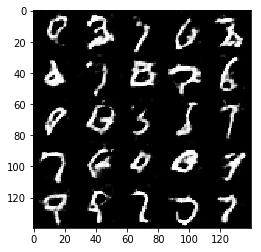

Epoch 2/2, discrimitor loss:0.5852 generator loss:1.9831
Epoch 2/2, discrimitor loss:0.5371 generator loss:2.1090
Epoch 2/2, discrimitor loss:0.5903 generator loss:1.7175
Epoch 2/2, discrimitor loss:0.7175 generator loss:1.3121
Epoch 2/2, discrimitor loss:0.5453 generator loss:2.1255
Epoch 2/2, discrimitor loss:0.5063 generator loss:2.2550
Epoch 2/2, discrimitor loss:0.4994 generator loss:2.1977


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, discrimitor loss:1.3221 generator loss:0.7032


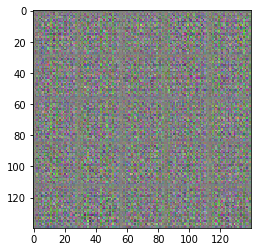

Epoch 1/1, discrimitor loss:0.5844 generator loss:2.4642
Epoch 1/1, discrimitor loss:0.5749 generator loss:2.7375
Epoch 1/1, discrimitor loss:0.4980 generator loss:3.1422
Epoch 1/1, discrimitor loss:0.5463 generator loss:2.9033
Epoch 1/1, discrimitor loss:0.4809 generator loss:3.2112
Epoch 1/1, discrimitor loss:0.4492 generator loss:3.2343
Epoch 1/1, discrimitor loss:0.4149 generator loss:3.6762
Epoch 1/1, discrimitor loss:0.4208 generator loss:3.6747
Epoch 1/1, discrimitor loss:0.4000 generator loss:3.7352
Epoch 1/1, discrimitor loss:0.4022 generator loss:3.8323


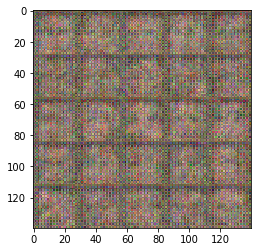

Epoch 1/1, discrimitor loss:0.4043 generator loss:3.7696
Epoch 1/1, discrimitor loss:0.4653 generator loss:2.8665
Epoch 1/1, discrimitor loss:0.4626 generator loss:2.7719
Epoch 1/1, discrimitor loss:0.4791 generator loss:3.4831
Epoch 1/1, discrimitor loss:0.5192 generator loss:2.3347
Epoch 1/1, discrimitor loss:0.4939 generator loss:2.6270
Epoch 1/1, discrimitor loss:0.6119 generator loss:1.8722
Epoch 1/1, discrimitor loss:0.5911 generator loss:3.5518
Epoch 1/1, discrimitor loss:0.5680 generator loss:2.9344
Epoch 1/1, discrimitor loss:0.6592 generator loss:1.7588


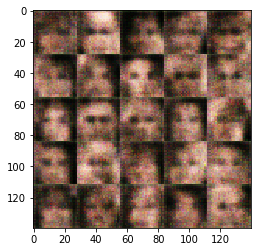

Epoch 1/1, discrimitor loss:0.5256 generator loss:2.8493
Epoch 1/1, discrimitor loss:0.5930 generator loss:1.9712
Epoch 1/1, discrimitor loss:0.5765 generator loss:1.9396
Epoch 1/1, discrimitor loss:0.5501 generator loss:2.9081
Epoch 1/1, discrimitor loss:0.5597 generator loss:2.4256
Epoch 1/1, discrimitor loss:0.5894 generator loss:3.1686
Epoch 1/1, discrimitor loss:0.6455 generator loss:3.2926
Epoch 1/1, discrimitor loss:0.6033 generator loss:1.7004
Epoch 1/1, discrimitor loss:0.6431 generator loss:1.8925
Epoch 1/1, discrimitor loss:0.9361 generator loss:3.2537


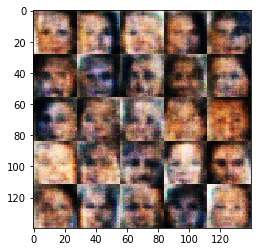

Epoch 1/1, discrimitor loss:0.6166 generator loss:2.6019
Epoch 1/1, discrimitor loss:0.8179 generator loss:2.7913
Epoch 1/1, discrimitor loss:0.5942 generator loss:2.1394
Epoch 1/1, discrimitor loss:0.9693 generator loss:0.9339
Epoch 1/1, discrimitor loss:0.9780 generator loss:1.0354
Epoch 1/1, discrimitor loss:0.5746 generator loss:2.1195
Epoch 1/1, discrimitor loss:0.6925 generator loss:2.0294
Epoch 1/1, discrimitor loss:0.6277 generator loss:2.1330
Epoch 1/1, discrimitor loss:0.6164 generator loss:2.0686
Epoch 1/1, discrimitor loss:0.6759 generator loss:1.7645


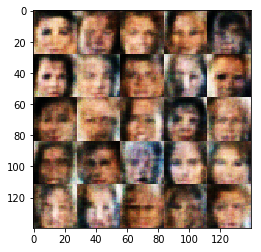

Epoch 1/1, discrimitor loss:0.8205 generator loss:1.4753
Epoch 1/1, discrimitor loss:0.8757 generator loss:1.4452
Epoch 1/1, discrimitor loss:0.7016 generator loss:2.4695
Epoch 1/1, discrimitor loss:0.8364 generator loss:2.3286
Epoch 1/1, discrimitor loss:0.6644 generator loss:1.8464
Epoch 1/1, discrimitor loss:0.7362 generator loss:1.6387
Epoch 1/1, discrimitor loss:0.6966 generator loss:1.7090
Epoch 1/1, discrimitor loss:0.7197 generator loss:1.5209
Epoch 1/1, discrimitor loss:0.6675 generator loss:1.5958
Epoch 1/1, discrimitor loss:0.7885 generator loss:2.7230


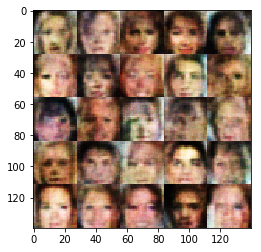

Epoch 1/1, discrimitor loss:1.1283 generator loss:0.9488
Epoch 1/1, discrimitor loss:1.0288 generator loss:2.1645
Epoch 1/1, discrimitor loss:1.1067 generator loss:1.1503
Epoch 1/1, discrimitor loss:1.0252 generator loss:1.7761
Epoch 1/1, discrimitor loss:0.7616 generator loss:1.6625
Epoch 1/1, discrimitor loss:0.8069 generator loss:1.2619
Epoch 1/1, discrimitor loss:0.7530 generator loss:1.7082
Epoch 1/1, discrimitor loss:0.7866 generator loss:1.6015
Epoch 1/1, discrimitor loss:0.8109 generator loss:1.5364
Epoch 1/1, discrimitor loss:0.8485 generator loss:2.2818


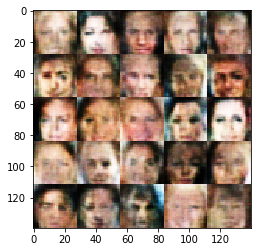

Epoch 1/1, discrimitor loss:0.8605 generator loss:1.9976
Epoch 1/1, discrimitor loss:0.8323 generator loss:1.5333
Epoch 1/1, discrimitor loss:0.9753 generator loss:0.8739
Epoch 1/1, discrimitor loss:0.8587 generator loss:1.4401
Epoch 1/1, discrimitor loss:0.9596 generator loss:1.4502
Epoch 1/1, discrimitor loss:0.9328 generator loss:1.2394
Epoch 1/1, discrimitor loss:0.8138 generator loss:1.5069
Epoch 1/1, discrimitor loss:1.0105 generator loss:1.1951
Epoch 1/1, discrimitor loss:0.9544 generator loss:1.7075
Epoch 1/1, discrimitor loss:1.1181 generator loss:0.8016


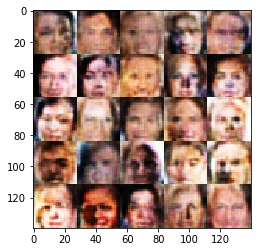

Epoch 1/1, discrimitor loss:0.9127 generator loss:1.1875
Epoch 1/1, discrimitor loss:0.9408 generator loss:1.2380
Epoch 1/1, discrimitor loss:0.8804 generator loss:1.3841
Epoch 1/1, discrimitor loss:0.9858 generator loss:1.0361
Epoch 1/1, discrimitor loss:0.8942 generator loss:1.3702
Epoch 1/1, discrimitor loss:0.9300 generator loss:1.1715
Epoch 1/1, discrimitor loss:0.9350 generator loss:1.4899
Epoch 1/1, discrimitor loss:0.9881 generator loss:1.6467
Epoch 1/1, discrimitor loss:0.8702 generator loss:1.6343
Epoch 1/1, discrimitor loss:0.8991 generator loss:1.1908


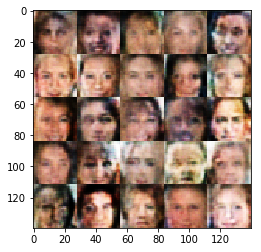

Epoch 1/1, discrimitor loss:1.0288 generator loss:0.9753
Epoch 1/1, discrimitor loss:1.0049 generator loss:1.0429
Epoch 1/1, discrimitor loss:0.9628 generator loss:1.5728
Epoch 1/1, discrimitor loss:0.9379 generator loss:1.3880
Epoch 1/1, discrimitor loss:0.8916 generator loss:1.5409
Epoch 1/1, discrimitor loss:0.9796 generator loss:1.0206
Epoch 1/1, discrimitor loss:0.9649 generator loss:1.5136
Epoch 1/1, discrimitor loss:0.9336 generator loss:1.1529
Epoch 1/1, discrimitor loss:0.9680 generator loss:1.3276
Epoch 1/1, discrimitor loss:0.9950 generator loss:1.4622


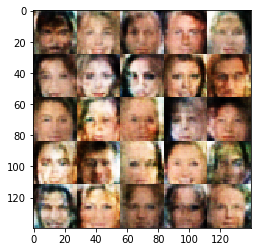

Epoch 1/1, discrimitor loss:0.9298 generator loss:1.7834
Epoch 1/1, discrimitor loss:0.9393 generator loss:1.6241
Epoch 1/1, discrimitor loss:0.9282 generator loss:1.8635
Epoch 1/1, discrimitor loss:0.9223 generator loss:1.5287
Epoch 1/1, discrimitor loss:0.9351 generator loss:1.0826
Epoch 1/1, discrimitor loss:1.1067 generator loss:0.7943
Epoch 1/1, discrimitor loss:1.0745 generator loss:0.9187
Epoch 1/1, discrimitor loss:0.9708 generator loss:1.3992
Epoch 1/1, discrimitor loss:0.9539 generator loss:1.3704
Epoch 1/1, discrimitor loss:1.0654 generator loss:0.7738


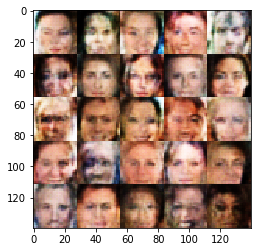

Epoch 1/1, discrimitor loss:0.9112 generator loss:1.5319
Epoch 1/1, discrimitor loss:1.0905 generator loss:0.8685
Epoch 1/1, discrimitor loss:1.0608 generator loss:1.6055
Epoch 1/1, discrimitor loss:0.9705 generator loss:1.4109
Epoch 1/1, discrimitor loss:0.9424 generator loss:1.7399
Epoch 1/1, discrimitor loss:0.9773 generator loss:1.2586
Epoch 1/1, discrimitor loss:0.9568 generator loss:1.2392
Epoch 1/1, discrimitor loss:0.9697 generator loss:1.1171
Epoch 1/1, discrimitor loss:0.9447 generator loss:1.0098
Epoch 1/1, discrimitor loss:0.9410 generator loss:1.8575


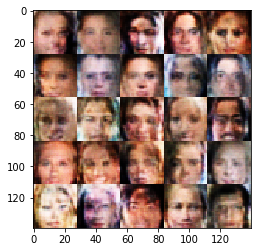

Epoch 1/1, discrimitor loss:0.9195 generator loss:1.5281
Epoch 1/1, discrimitor loss:0.8343 generator loss:1.5889
Epoch 1/1, discrimitor loss:1.1307 generator loss:1.9929
Epoch 1/1, discrimitor loss:1.0830 generator loss:2.1335
Epoch 1/1, discrimitor loss:0.9170 generator loss:1.2848
Epoch 1/1, discrimitor loss:0.9182 generator loss:1.5840
Epoch 1/1, discrimitor loss:1.0218 generator loss:1.8306
Epoch 1/1, discrimitor loss:0.9757 generator loss:1.7762
Epoch 1/1, discrimitor loss:0.9399 generator loss:1.3346
Epoch 1/1, discrimitor loss:0.8997 generator loss:1.6246


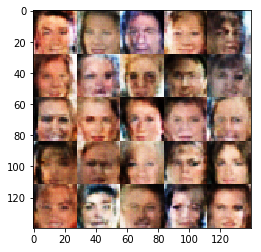

Epoch 1/1, discrimitor loss:0.9926 generator loss:1.2820
Epoch 1/1, discrimitor loss:0.9167 generator loss:1.7840
Epoch 1/1, discrimitor loss:1.0289 generator loss:1.2690
Epoch 1/1, discrimitor loss:0.9679 generator loss:1.5794
Epoch 1/1, discrimitor loss:1.0480 generator loss:1.8940
Epoch 1/1, discrimitor loss:0.9555 generator loss:1.2443
Epoch 1/1, discrimitor loss:1.0524 generator loss:0.9987
Epoch 1/1, discrimitor loss:0.9776 generator loss:1.1558
Epoch 1/1, discrimitor loss:0.9390 generator loss:1.2661
Epoch 1/1, discrimitor loss:0.8736 generator loss:1.3849


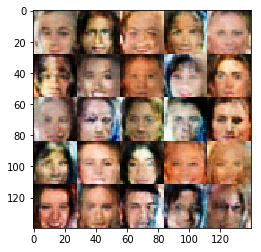

Epoch 1/1, discrimitor loss:0.8993 generator loss:1.6860
Epoch 1/1, discrimitor loss:0.8755 generator loss:1.6560
Epoch 1/1, discrimitor loss:0.9403 generator loss:1.5078
Epoch 1/1, discrimitor loss:0.8988 generator loss:1.1333
Epoch 1/1, discrimitor loss:0.8698 generator loss:1.6640
Epoch 1/1, discrimitor loss:0.9540 generator loss:1.3574
Epoch 1/1, discrimitor loss:1.0039 generator loss:0.9379
Epoch 1/1, discrimitor loss:0.9816 generator loss:0.9658
Epoch 1/1, discrimitor loss:0.9016 generator loss:1.0655
Epoch 1/1, discrimitor loss:0.9639 generator loss:1.2825


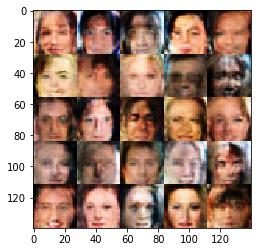

Epoch 1/1, discrimitor loss:0.9613 generator loss:1.1353
Epoch 1/1, discrimitor loss:0.9045 generator loss:1.4160
Epoch 1/1, discrimitor loss:0.8573 generator loss:1.3559
Epoch 1/1, discrimitor loss:0.8815 generator loss:1.5776
Epoch 1/1, discrimitor loss:1.0056 generator loss:0.9428
Epoch 1/1, discrimitor loss:0.9193 generator loss:1.0718
Epoch 1/1, discrimitor loss:0.8433 generator loss:1.7115
Epoch 1/1, discrimitor loss:0.9143 generator loss:1.5424
Epoch 1/1, discrimitor loss:1.0119 generator loss:1.1392
Epoch 1/1, discrimitor loss:0.9283 generator loss:1.7613


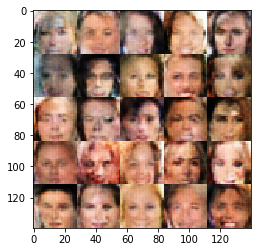

Epoch 1/1, discrimitor loss:0.9886 generator loss:1.1829
Epoch 1/1, discrimitor loss:1.1068 generator loss:0.8812
Epoch 1/1, discrimitor loss:0.9235 generator loss:1.2018
Epoch 1/1, discrimitor loss:0.8748 generator loss:1.3026
Epoch 1/1, discrimitor loss:0.9060 generator loss:1.5522
Epoch 1/1, discrimitor loss:0.9294 generator loss:1.5313
Epoch 1/1, discrimitor loss:1.0340 generator loss:0.8452
Epoch 1/1, discrimitor loss:0.9030 generator loss:1.6732
Epoch 1/1, discrimitor loss:0.8945 generator loss:1.3261
Epoch 1/1, discrimitor loss:0.9063 generator loss:1.2527


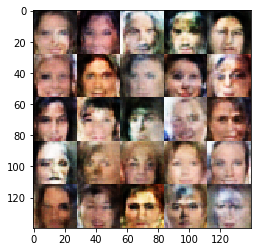

Epoch 1/1, discrimitor loss:0.9706 generator loss:1.1244
Epoch 1/1, discrimitor loss:0.9088 generator loss:1.2896
Epoch 1/1, discrimitor loss:0.8838 generator loss:2.0464
Epoch 1/1, discrimitor loss:0.9315 generator loss:1.1942
Epoch 1/1, discrimitor loss:1.1202 generator loss:2.0932
Epoch 1/1, discrimitor loss:0.9219 generator loss:1.1764
Epoch 1/1, discrimitor loss:0.8277 generator loss:1.4229
Epoch 1/1, discrimitor loss:0.9107 generator loss:1.4753
Epoch 1/1, discrimitor loss:0.9663 generator loss:1.0624
Epoch 1/1, discrimitor loss:0.9677 generator loss:1.2074


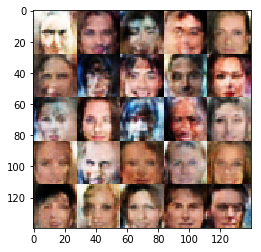

Epoch 1/1, discrimitor loss:1.1409 generator loss:0.8301
Epoch 1/1, discrimitor loss:0.9980 generator loss:1.3642
Epoch 1/1, discrimitor loss:0.9812 generator loss:1.0793
Epoch 1/1, discrimitor loss:0.9112 generator loss:1.6247
Epoch 1/1, discrimitor loss:0.9880 generator loss:1.0452
Epoch 1/1, discrimitor loss:1.2659 generator loss:0.6158
Epoch 1/1, discrimitor loss:0.8482 generator loss:1.3958
Epoch 1/1, discrimitor loss:0.9887 generator loss:1.5760
Epoch 1/1, discrimitor loss:1.0450 generator loss:0.9515
Epoch 1/1, discrimitor loss:1.0698 generator loss:0.8359


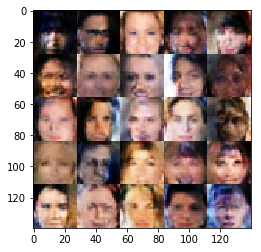

Epoch 1/1, discrimitor loss:1.0318 generator loss:1.0990
Epoch 1/1, discrimitor loss:0.8863 generator loss:1.2479
Epoch 1/1, discrimitor loss:0.8353 generator loss:1.6067
Epoch 1/1, discrimitor loss:0.9824 generator loss:0.9998
Epoch 1/1, discrimitor loss:0.9771 generator loss:1.2633
Epoch 1/1, discrimitor loss:1.0687 generator loss:1.0425
Epoch 1/1, discrimitor loss:0.9635 generator loss:1.5167
Epoch 1/1, discrimitor loss:1.0246 generator loss:1.1108
Epoch 1/1, discrimitor loss:1.0103 generator loss:1.2805
Epoch 1/1, discrimitor loss:2.4256 generator loss:4.0209


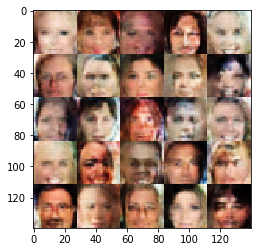

Epoch 1/1, discrimitor loss:1.1439 generator loss:1.4018
Epoch 1/1, discrimitor loss:1.0006 generator loss:1.3916
Epoch 1/1, discrimitor loss:0.9817 generator loss:1.1159
Epoch 1/1, discrimitor loss:0.8610 generator loss:1.6433
Epoch 1/1, discrimitor loss:1.0043 generator loss:1.1035
Epoch 1/1, discrimitor loss:1.0792 generator loss:1.8106
Epoch 1/1, discrimitor loss:1.1717 generator loss:0.7273
Epoch 1/1, discrimitor loss:0.9787 generator loss:1.4714
Epoch 1/1, discrimitor loss:0.9594 generator loss:1.1235
Epoch 1/1, discrimitor loss:0.9653 generator loss:1.3001


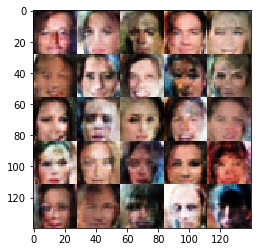

Epoch 1/1, discrimitor loss:0.9767 generator loss:1.3602
Epoch 1/1, discrimitor loss:1.0124 generator loss:0.9450
Epoch 1/1, discrimitor loss:1.0112 generator loss:1.1606
Epoch 1/1, discrimitor loss:0.8395 generator loss:1.7694
Epoch 1/1, discrimitor loss:0.9899 generator loss:0.9794
Epoch 1/1, discrimitor loss:0.8725 generator loss:1.3216
Epoch 1/1, discrimitor loss:0.9515 generator loss:1.3649
Epoch 1/1, discrimitor loss:1.0821 generator loss:1.7420
Epoch 1/1, discrimitor loss:0.9606 generator loss:1.7620
Epoch 1/1, discrimitor loss:0.9495 generator loss:1.3509


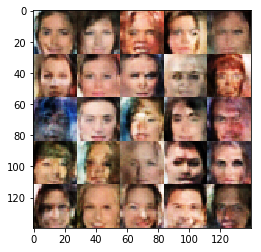

Epoch 1/1, discrimitor loss:1.0291 generator loss:1.0830
Epoch 1/1, discrimitor loss:0.9222 generator loss:1.3925
Epoch 1/1, discrimitor loss:1.0181 generator loss:1.1818
Epoch 1/1, discrimitor loss:0.9467 generator loss:1.2280
Epoch 1/1, discrimitor loss:0.9753 generator loss:1.5379
Epoch 1/1, discrimitor loss:0.8715 generator loss:1.6143
Epoch 1/1, discrimitor loss:0.9501 generator loss:1.8672
Epoch 1/1, discrimitor loss:0.8746 generator loss:1.1853
Epoch 1/1, discrimitor loss:1.1084 generator loss:0.8734
Epoch 1/1, discrimitor loss:1.0232 generator loss:1.9560


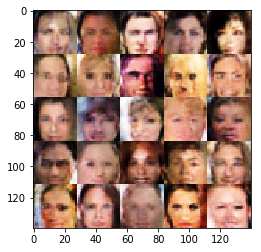

Epoch 1/1, discrimitor loss:0.9671 generator loss:1.3811
Epoch 1/1, discrimitor loss:0.9365 generator loss:1.2414
Epoch 1/1, discrimitor loss:0.9883 generator loss:1.4441
Epoch 1/1, discrimitor loss:1.1095 generator loss:0.8465
Epoch 1/1, discrimitor loss:1.1276 generator loss:0.7078
Epoch 1/1, discrimitor loss:1.7240 generator loss:3.9097
Epoch 1/1, discrimitor loss:0.9271 generator loss:1.3985
Epoch 1/1, discrimitor loss:0.9367 generator loss:1.4410
Epoch 1/1, discrimitor loss:0.7964 generator loss:1.5952
Epoch 1/1, discrimitor loss:0.9289 generator loss:1.2546


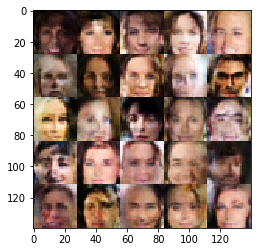

Epoch 1/1, discrimitor loss:1.0289 generator loss:1.5598
Epoch 1/1, discrimitor loss:0.9350 generator loss:1.2988
Epoch 1/1, discrimitor loss:1.0589 generator loss:1.0323
Epoch 1/1, discrimitor loss:1.0169 generator loss:1.2093
Epoch 1/1, discrimitor loss:1.0348 generator loss:0.9535
Epoch 1/1, discrimitor loss:1.1078 generator loss:1.3664
Epoch 1/1, discrimitor loss:0.7851 generator loss:1.7185
Epoch 1/1, discrimitor loss:0.9494 generator loss:1.1701
Epoch 1/1, discrimitor loss:1.0104 generator loss:1.2652
Epoch 1/1, discrimitor loss:0.8890 generator loss:1.8112


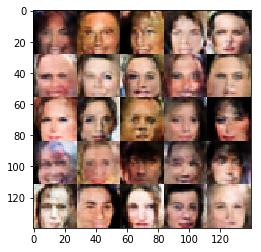

Epoch 1/1, discrimitor loss:1.0493 generator loss:1.0866
Epoch 1/1, discrimitor loss:0.8019 generator loss:1.6104
Epoch 1/1, discrimitor loss:0.9314 generator loss:1.5976
Epoch 1/1, discrimitor loss:0.9587 generator loss:1.3017
Epoch 1/1, discrimitor loss:0.9353 generator loss:1.3157
Epoch 1/1, discrimitor loss:1.0191 generator loss:1.0381
Epoch 1/1, discrimitor loss:0.8975 generator loss:1.2135
Epoch 1/1, discrimitor loss:1.0332 generator loss:0.9991
Epoch 1/1, discrimitor loss:1.0708 generator loss:1.6334
Epoch 1/1, discrimitor loss:1.0280 generator loss:1.1081


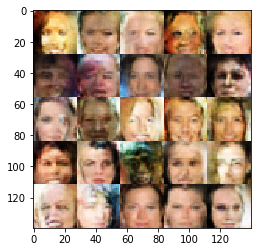

Epoch 1/1, discrimitor loss:0.8948 generator loss:1.4050
Epoch 1/1, discrimitor loss:1.0165 generator loss:1.1037
Epoch 1/1, discrimitor loss:1.0024 generator loss:0.8878
Epoch 1/1, discrimitor loss:1.0318 generator loss:1.1060
Epoch 1/1, discrimitor loss:0.9292 generator loss:1.2061
Epoch 1/1, discrimitor loss:0.9627 generator loss:1.4836
Epoch 1/1, discrimitor loss:0.9118 generator loss:1.3220
Epoch 1/1, discrimitor loss:1.0276 generator loss:1.3228
Epoch 1/1, discrimitor loss:1.0235 generator loss:0.9984
Epoch 1/1, discrimitor loss:1.0294 generator loss:1.2465


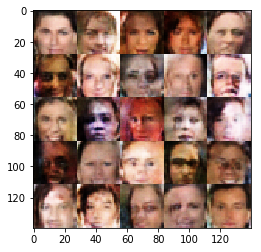

Epoch 1/1, discrimitor loss:0.9707 generator loss:1.2234
Epoch 1/1, discrimitor loss:1.0216 generator loss:1.7216
Epoch 1/1, discrimitor loss:0.8971 generator loss:1.8019
Epoch 1/1, discrimitor loss:0.9467 generator loss:1.2855
Epoch 1/1, discrimitor loss:1.1498 generator loss:1.6173
Epoch 1/1, discrimitor loss:1.0417 generator loss:0.9562
Epoch 1/1, discrimitor loss:0.9418 generator loss:1.2734
Epoch 1/1, discrimitor loss:1.0288 generator loss:0.9856
Epoch 1/1, discrimitor loss:0.9301 generator loss:1.1082
Epoch 1/1, discrimitor loss:0.9482 generator loss:1.4177


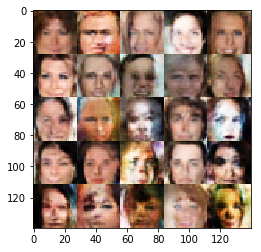

Epoch 1/1, discrimitor loss:0.9389 generator loss:1.4277
Epoch 1/1, discrimitor loss:1.0442 generator loss:1.1059
Epoch 1/1, discrimitor loss:0.9405 generator loss:1.4758
Epoch 1/1, discrimitor loss:1.0821 generator loss:1.0786
Epoch 1/1, discrimitor loss:1.1383 generator loss:0.7801
Epoch 1/1, discrimitor loss:0.8895 generator loss:1.4069
Epoch 1/1, discrimitor loss:2.7568 generator loss:4.5457
Epoch 1/1, discrimitor loss:1.2563 generator loss:1.0471
Epoch 1/1, discrimitor loss:0.9739 generator loss:1.5949
Epoch 1/1, discrimitor loss:0.9390 generator loss:1.2309


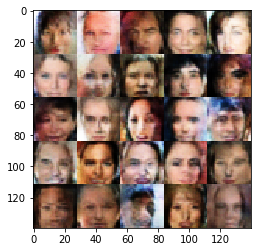

Epoch 1/1, discrimitor loss:0.9775 generator loss:1.0526
Epoch 1/1, discrimitor loss:0.9477 generator loss:1.1821
Epoch 1/1, discrimitor loss:0.9004 generator loss:1.4602
Epoch 1/1, discrimitor loss:0.9338 generator loss:1.2461
Epoch 1/1, discrimitor loss:1.0436 generator loss:0.9100
Epoch 1/1, discrimitor loss:0.9399 generator loss:1.3964
Epoch 1/1, discrimitor loss:0.9832 generator loss:1.0798
Epoch 1/1, discrimitor loss:1.0760 generator loss:1.2100
Epoch 1/1, discrimitor loss:0.8681 generator loss:1.7074
Epoch 1/1, discrimitor loss:0.9302 generator loss:1.5653


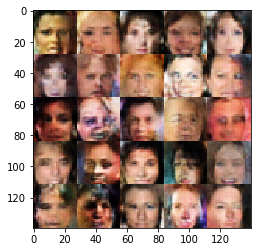

Epoch 1/1, discrimitor loss:0.9817 generator loss:1.2488
Epoch 1/1, discrimitor loss:0.9816 generator loss:1.1552
Epoch 1/1, discrimitor loss:0.9572 generator loss:1.1207
Epoch 1/1, discrimitor loss:0.9472 generator loss:1.4651
Epoch 1/1, discrimitor loss:1.0836 generator loss:0.9846
Epoch 1/1, discrimitor loss:0.9193 generator loss:1.3478
Epoch 1/1, discrimitor loss:1.0627 generator loss:0.9271
Epoch 1/1, discrimitor loss:0.9588 generator loss:1.7481
Epoch 1/1, discrimitor loss:0.9187 generator loss:1.2354
Epoch 1/1, discrimitor loss:1.0658 generator loss:1.2916


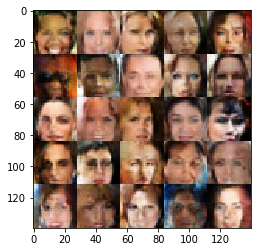

Epoch 1/1, discrimitor loss:0.8919 generator loss:1.3950
Epoch 1/1, discrimitor loss:1.1116 generator loss:0.8761
Epoch 1/1, discrimitor loss:1.1275 generator loss:0.8434
Epoch 1/1, discrimitor loss:0.9264 generator loss:1.4398
Epoch 1/1, discrimitor loss:0.9718 generator loss:1.2987
Epoch 1/1, discrimitor loss:1.0064 generator loss:0.9788
Epoch 1/1, discrimitor loss:1.0172 generator loss:1.3295
Epoch 1/1, discrimitor loss:0.8847 generator loss:1.3487
Epoch 1/1, discrimitor loss:1.0237 generator loss:0.9999
Epoch 1/1, discrimitor loss:0.8777 generator loss:1.6672


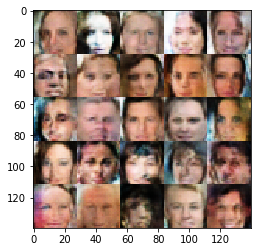

Epoch 1/1, discrimitor loss:0.9458 generator loss:1.1863
Epoch 1/1, discrimitor loss:0.9357 generator loss:1.3208
Epoch 1/1, discrimitor loss:0.9530 generator loss:1.4433
Epoch 1/1, discrimitor loss:0.9724 generator loss:1.1762
Epoch 1/1, discrimitor loss:1.2210 generator loss:0.6817
Epoch 1/1, discrimitor loss:0.8145 generator loss:1.6814


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.